##Importing Libaries

In [1]:
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

##Data Preprocessing

In [2]:
#!unzip
from google.colab import drive
import zipfile
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in Google Drive
zip_path = '/content/drive/My Drive/HDA-PlasticSurgery.zip'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')
data_dir = '/content/'

# List of surgery types
surgery_types = ['Eyebrow', 'Eyelid', 'Facelift', 'FacialBones', 'Nose']

# Desired image size
img_height, img_width = 256, 256

# Initialize lists to hold data and labels
before_images = []
after_images = []
labels = []  # Optional: if you want to encode the surgery type as a label

for s_type in surgery_types:
    folder_path = os.path.join(data_dir, s_type)

    # Get all images in the folder
    all_images = sorted(glob.glob(os.path.join(folder_path, '*.jpg')))

    # Group images by their base ID (e.g., '01' in '01_a.jpg' and '01_b.jpg')
    # We assume each pair is something like "XX_a.jpg" and "XX_b.jpg"
    # We'll create a dictionary to track pairs.
    pairs = {}
    for img_path in all_images:
        filename = os.path.basename(img_path)
        base_id = filename.split('_')[0]  # e.g., '01' from '01_a.jpg'
        suffix = filename.split('_')[1].split('.')[0]  # 'a' or 'b'

        if base_id not in pairs:
            pairs[base_id] = {}
        pairs[base_id][suffix] = img_path

    # Now pairs dict should look like:
    # {
    #   "01": {"a": "path/to/01_a.jpg", "b": "path/to/01_b.jpg"},
    #   "02": {"a": "path/to/02_a.jpg", "b": "path/to/02_b.jpg"},
    #   ...
    # }

    # Load the images and append them to our datasets
    for base_id, pair_paths in pairs.items():
        if 'a' in pair_paths and 'b' in pair_paths:
            # Load after (a) and before (b) images
            after_img = cv2.imread(pair_paths['a'])
            before_img = cv2.imread(pair_paths['b'])

            # Convert to RGB if needed
            after_img = cv2.cvtColor(after_img, cv2.COLOR_BGR2RGB)
            before_img = cv2.cvtColor(before_img, cv2.COLOR_BGR2RGB)

            # Resize images
            after_img = cv2.resize(after_img, (img_width, img_height))
            before_img = cv2.resize(before_img, (img_width, img_height))

            # Normalize images to [0,1]
            after_img = after_img.astype('float32') / 255.0
            before_img = before_img.astype('float32') / 255.0

            # Append to lists
            after_images.append(after_img)
            before_images.append(before_img)

            # If you want to keep track of surgery type (e.g., one-hot encode it)
            # This is optional and depends on your use case
            labels.append(s_type)

# Convert lists to numpy arrays
before_images = np.array(before_images)
after_images = np.array(after_images)

# If using labels, convert to numpy array
labels = np.array(labels)

# Optional: If you want to encode surgery types as integers or one-hot vectors
# For example, map them to integers:
type_to_idx = {st: i for i, st in enumerate(surgery_types)}
int_labels = np.array([type_to_idx[l] for l in labels])

# Split into train, validation, test
# Here, we split the entire dataset into 80% train, 10% val, 10% test
X_train_before, X_temp_before, X_train_after, X_temp_after, y_train, y_temp = train_test_split(
    before_images, after_images, int_labels, test_size=0.2, random_state=42, stratify=int_labels
)

X_val_before, X_test_before, X_val_after, X_test_after, y_val, y_test = train_test_split(
    X_temp_before, X_temp_after, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Now you have:
# X_train_before, X_train_after, y_train
# X_val_before, X_val_after, y_val
# X_test_before, X_test_after, y_test

print("Training set size:", X_train_before.shape, X_train_after.shape)
print("Validation set size:", X_val_before.shape, X_val_after.shape)
print("Test set size:", X_test_before.shape, X_test_after.shape)

Mounted at /content/drive
Training set size: (508, 256, 256, 3) (508, 256, 256, 3)
Validation set size: (63, 256, 256, 3) (63, 256, 256, 3)
Test set size: (64, 256, 256, 3) (64, 256, 256, 3)


##Dataset Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Assuming type_to_idx is already defined from the preprocessing step
# Example:
# type_to_idx = {'Eyebrow': 0, 'Eyelid': 1, 'Facelift': 2, 'FacialBones': 3, 'Nose': 4}

# Create a reverse lookup dictionary to get surgery type names from integer labels
idx_to_type = {v: k for k, v in type_to_idx.items()}

def visualize_one_sample_per_type(X_before, X_after, y, type_to_idx):
    """
    Visualizes one random before-and-after image pair for each surgery type.

    Parameters:
    - X_before: Numpy array of "before" images.
    - X_after: Numpy array of "after" images.
    - y: Numpy array of integer-encoded labels.
    - type_to_idx: Dictionary mapping surgery type names to integer labels.
    """
    num_types = len(type_to_idx)
    surgery_types = list(type_to_idx.keys())

    # Initialize a list to store selected indices
    selected_indices = []

    for s_type in surgery_types:
        # Get the integer label for the current surgery type
        label = type_to_idx[s_type]

        # Find all indices where the label matches the current surgery type
        indices = np.where(y == label)[0]

        if len(indices) == 0:
            print(f"No samples found for surgery type: {s_type}")
            continue

        # Randomly select one index from the available indices
        selected_idx = random.choice(indices)
        selected_indices.append(selected_idx)

    # Number of valid surgery types with at least one sample
    valid_num_types = len(selected_indices)

    # Create a figure with subplots: rows = number of surgery types, cols = 2 (Before & After)
    fig, axes = plt.subplots(nrows=valid_num_types, ncols=2, figsize=(10, 5 * valid_num_types))

    # If there's only one surgery type, axes might not be a 2D array
    if valid_num_types == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, idx in enumerate(selected_indices):
        s_type = idx_to_type[y[idx]]

        # Before Image
        before_img = X_before[idx]
        axes[i, 0].imshow(before_img)
        axes[i, 0].set_title(f"Before - {s_type}")
        axes[i, 0].axis('off')

        # After Image
        after_img = X_after[idx]
        axes[i, 1].imshow(after_img)
        axes[i, 1].set_title(f"After - {s_type}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to visualize one sample per surgery type from the training set
visualize_one_sample_per_type(X_train_before, X_train_after, y_train, type_to_idx)

##Model Architecture
*   Classifier (CNN): Identifies and ensures that the generated image matches the target surgery type.
*   Generator (GAN): Produces the "after" image based on the input "before" image and surgery type.
*   Discriminator (GAN): Evaluates whether the generated "after" image is realistic.

**Generator:**
Takes a "before" image and surgery type as input and generates a "realistic after" image.

In [4]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU, Embedding, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf

def build_generator(img_shape, num_types):
    input_img = Input(shape=img_shape, name='before_image')
    surgery_type = Input(shape=(1,), name='surgery_type')

    # Embed surgery type
    surgery_embedding = Embedding(num_types, 50)(surgery_type)
    surgery_embedding = Dense(img_shape[0] * img_shape[1], activation='relu')(surgery_embedding)
    surgery_embedding = Reshape((img_shape[0], img_shape[1], 1))(surgery_embedding)

    # Concatenate inputs
    concatenated = Concatenate()([input_img, surgery_embedding])

    # Generator network
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(concatenated)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(x)

    generator = Model([input_img, surgery_type], x, name="generator")
    return generator


**Discriminator:**
Evaluates whether the generated "after" image is realistic and consistent with the surgery type.

In [5]:
def build_discriminator(img_shape, num_types):
    input_img = Input(shape=img_shape, name='after_image')
    surgery_type = Input(shape=(1,), name='surgery_type')

    # Embed surgery type
    surgery_embedding = Embedding(num_types, 50)(surgery_type)
    surgery_embedding = Dense(img_shape[0] * img_shape[1], activation='relu')(surgery_embedding)
    surgery_embedding = Reshape((img_shape[0], img_shape[1], 1))(surgery_embedding)

    # Concatenate inputs
    concatenated = Concatenate()([input_img, surgery_embedding])

    # Discriminator network
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(concatenated)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    discriminator = Model([input_img, surgery_type], x, name="discriminator")
    return discriminator


**CNN:**
classify the type of surgery based on "before" images.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_cnn_classifier(img_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=img_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Example usage
img_shape = (128, 128, 3) # Replace with your image dimensions
num_classes = 5           # Replace with the number of surgery types
classifier = build_cnn_classifier(img_shape, num_classes)
classifier.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

**Data Preparation for GAN**

In [7]:
def prepare_gan_data(before_images, after_images, labels, surgery_types):
    """
    Prepares data for GAN training by combining images and labels.
    """
    num_types = len(surgery_types)
    type_to_idx = {st: i for i, st in enumerate(surgery_types)}

    # Convert surgery types to one-hot encoding
    one_hot_labels = np.eye(num_types)[labels]

    # Generator input: before images + surgery type (as one-hot)
    generator_input = [before_images, one_hot_labels]

    # Discriminator input: real after images + surgery type (as one-hot)
    discriminator_input_real = [after_images, one_hot_labels]

    # Discriminator input: fake after images + surgery type (as one-hot)
    # To be generated dynamically during GAN training.

    return generator_input, discriminator_input_real


##Training Steps

Train the CNN

In [8]:
# Build and compile the CNN classifier
img_shape = X_train_before.shape[1:]  # Get image shape from training data
num_classes = len(surgery_types)     # Number of surgery types
classifier = build_cnn_classifier(img_shape, num_classes)

# Train the CNN
history = classifier.fit(X_train_before, y_train, validation_data=(X_val_before, y_val), epochs=20, batch_size=32)
classifier.save("cnn_classifier_model.h5")

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 987ms/step - accuracy: 0.2193 - loss: 11.4598 - val_accuracy: 0.2063 - val_loss: 1.6034
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.2451 - loss: 1.5904 - val_accuracy: 0.3333 - val_loss: 1.5955
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3033 - loss: 1.5773 - val_accuracy: 0.2857 - val_loss: 1.5559
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3492 - loss: 1.5413 - val_accuracy: 0.3333 - val_loss: 1.5209
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3979 - loss: 1.4637 - val_accuracy: 0.3651 - val_loss: 1.4946
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.4294 - loss: 1.3470 - val_accuracy: 0.4286 - val_loss: 1.4213
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5085 - loss: 1.2730 - val_accuracy: 0.4286 - val_loss: 1.3835
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6670 - loss: 1.0411 - val_accuracy: 0.4444 

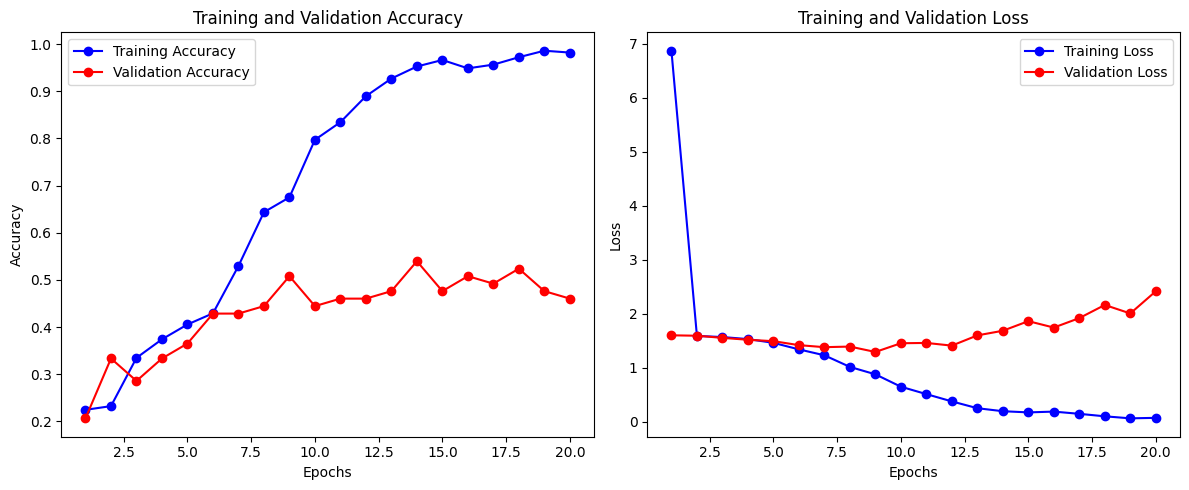

In [9]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


**Train GAN Function:** It combines the generator and discriminator into a single pipeline for GAN training. The function uses the adversarial training approach to train both models alternately.

In [ ]:
def train_gan(generator, discriminator, img_shape, surgery_types, epochs=10000, batch_size=32, save_interval=500):
    """
    Trains the GAN by alternately training the generator and discriminator.

    Parameters:
    - generator: The generator model.
    - discriminator: The discriminator model.
    - img_shape: Shape of the input images (height, width, channels).
    - surgery_types: List of surgery type labels.
    - epochs: Number of training iterations.
    - batch_size: Number of samples per training batch.
    - save_interval: Frequency (in epochs) to save and visualize results.
    """
    # Number of surgery types
    num_types = len(surgery_types)

    # Compile discriminator
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

    # Combine generator and discriminator for adversarial training
    z_before = Input(shape=img_shape)  # Input for before image
    z_label = Input(shape=(num_types,))  # Input for surgery type (one-hot encoded)

    # Generate fake after images
    fake_after = generator([z_before, z_label])

    # Freeze the discriminator when training the generator
    discriminator.trainable = False

    # Get discriminator output for generated images
    valid = discriminator([fake_after, z_label])

    # Combined model (generator + discriminator)
    combined = Model([z_before, z_label], valid)
    combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    # Training data placeholders
    valid_labels = np.ones((batch_size, 1))  # Labels for real images
    fake_labels = np.zeros((batch_size, 1))  # Labels for fake images

    for epoch in range(epochs):
        # -------------------------
        # Train Discriminator
        # -------------------------

        # Select a random batch of before images and corresponding surgery types
        idx = np.random.randint(0, before_images.shape[0], batch_size)
        real_before = before_images[idx]
        real_after = after_images[idx]
        labels = int_labels[idx]

        # One-hot encode surgery type labels
        labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=num_types)

        # Generate fake after images
        fake_after = generator.predict([real_before, labels_one_hot])

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch([real_after, labels_one_hot], valid_labels)
        d_loss_fake = discriminator.train_on_batch([fake_after, labels_one_hot], fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # -------------------------
        # Train Generator
        # -------------------------

        # Train the generator (discriminator should predict valid for generated images)
        g_loss = combined.train_on_batch([real_before, labels_one_hot], valid_labels)

        # Print progress
        print(f"{epoch + 1}/{epochs} [D loss: {d_loss[0]:.4f}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

        # If at save interval, save and visualize results
        if (epoch + 1) % save_interval == 0:
            save_and_visualize_results(epoch + 1, generator, surgery_types)


#surgery_types = ["Type A", "Type B", "Type C", "Type D", "Type E"]
#save_interval = 500

#train_gan(generator, discriminator, img_shape, surgery_types, epochs=10000, batch_size=32, save_interval=save_interval)



Saves and visualizes generated images during GAN training.

In [ ]:
#should run this before the previous cell
def save_and_visualize_results(epoch, generator, surgery_types):
    """
    Saves and visualizes generated images during GAN training.

    Parameters:
    - epoch: Current epoch number.
    - generator: The generator model.
    - surgery_types: List of surgery type labels.
    """
    r, c = 2, len(surgery_types)  # Rows and columns for visualization grid
    fig, axs = plt.subplots(r, c, figsize=(c * 2, r * 2))

    for i, s_type in enumerate(surgery_types):
        # Select a random before image
        idx = np.random.randint(0, before_images.shape[0])
        before_img = before_images[idx:idx + 1]

        # One-hot encode surgery type
        s_label = np.zeros((1, len(surgery_types)))
        s_label[0, i] = 1

        # Generate after image
        generated_img = generator.predict([before_img, s_label])[0]

        # Plot before image
        axs[0, i].imshow(before_img[0])
        axs[0, i].set_title(f"Before ({s_type})")
        axs[0, i].axis('off')

        # Plot generated after image
        axs[1, i].imshow(generated_img)
        axs[1, i].set_title(f"Generated After ({s_type})")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.show()


##Evaluation